# Identificación de personas con gafas en imágenes

## Introducción

Aquí se explica todo lo relacionado con el datasety lo que se busca implementar (Santiago se encarga)

## Implementación

### Imports

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import random

### Extracción de los datos

Definimos una constante con los nombres de las carpetas dónde se encuentran los archivos

In [3]:
carpetas = ['an2i', 'at33', 'boland', 'bpm', 'ch4f', 'cheyer', 'choon',
            'danieln', 'glickman', 'karyadi', 'kawamura', 'kk49', 'megak',
            'mitchell', 'night', 'phoebe', 'saavik', 'steffi', 'sz24', 'tammo']

Recorremos las carpetas para extraer las direcciones de las imágenes

In [4]:
direcciones_archivos =[]
for nombre in carpetas:
    direcciones_archivos += glob.glob(".\\faces\\"+nombre+"\\*.pgm")

Generamos listas para separar los datos según su resolución (entera, media o de un cuarto) y si tienen gafas o no, además de otras listas dónde se guardarán la información sobre la posición y la emoción expresada de las caras en las fotografías

In [5]:
entera_imagenes = []
entera_nombres = []
entera_sin_gafas_imagenes = []
entera_con_gafas_imagenes = []
entera_sin_gafas_nombres = []
entera_con_gafas_nombres = []

media_imagenes = []
media_nombres = []
media_sin_gafas_imagenes = []
media_con_gafas_imagenes = []
media_sin_gafas_nombres = []
media_con_gafas_nombres = []

cuarto_imagenes = []
cuarto_nombres = []
cuarto_sin_gafas_imagenes = []
cuarto_con_gafas_imagenes = []
cuarto_sin_gafas_nombres = []
cuarto_con_gafas_nombres = []

Recorremos las direcciones de archivos para poblar las listas anteriores, segregando los archivos por resolución, y por si tienen gafas o no, además de la información que se puede extraer de los títulos de las imágenes. También se hace una lista con todos los archivos completos en caso de necesitarse después

In [6]:
for direccion in direcciones_archivos:
    imagen = cv2.imread(direccion)
    nuevo_nombre = direccion.split('\\')[3].replace(".pgm","").split("_")
    if "4" in nuevo_nombre:
        cuarto_imagenes.append(imagen)
        cuarto_nombres.append(nuevo_nombre[1:4])
        if nuevo_nombre[3] == 'open':
            cuarto_sin_gafas_imagenes.append(imagen)
            cuarto_sin_gafas_nombres.append(nuevo_nombre[1:3])
        else:
            cuarto_con_gafas_imagenes.append(imagen)
            cuarto_con_gafas_nombres.append(nuevo_nombre[1:3])
    elif "2" in nuevo_nombre:
        media_imagenes.append(imagen)
        media_nombres.append(nuevo_nombre[1:4])
        if nuevo_nombre[3] == 'open':
            media_sin_gafas_imagenes.append(imagen)
            media_sin_gafas_nombres.append(nuevo_nombre[1:3])
        else:
            media_con_gafas_imagenes.append(imagen)
            media_con_gafas_nombres.append(nuevo_nombre[1:3])
    else:
        entera_imagenes.append(imagen)
        entera_nombres.append(nuevo_nombre[1:])
        if nuevo_nombre[3] == 'open':
            entera_sin_gafas_imagenes.append(imagen)
            entera_sin_gafas_nombres.append(nuevo_nombre[1:3])
        else:
            entera_con_gafas_imagenes.append(imagen)
            entera_con_gafas_nombres.append(nuevo_nombre[1:3])

### Análisis de los datos

In [23]:
elegidas = []
elegidas_con_gafas = []
elegidas_sin_gafas = []
for i in range(0,9):
    elegidas.append(random.randint(0,len(entera_imagenes)))
    elegidas_con_gafas.append(random.randint(0,len(entera_con_gafas_imagenes)))
    elegidas_sin_gafas.append(random.randint(0,len(entera_sin_gafas_imagenes)))

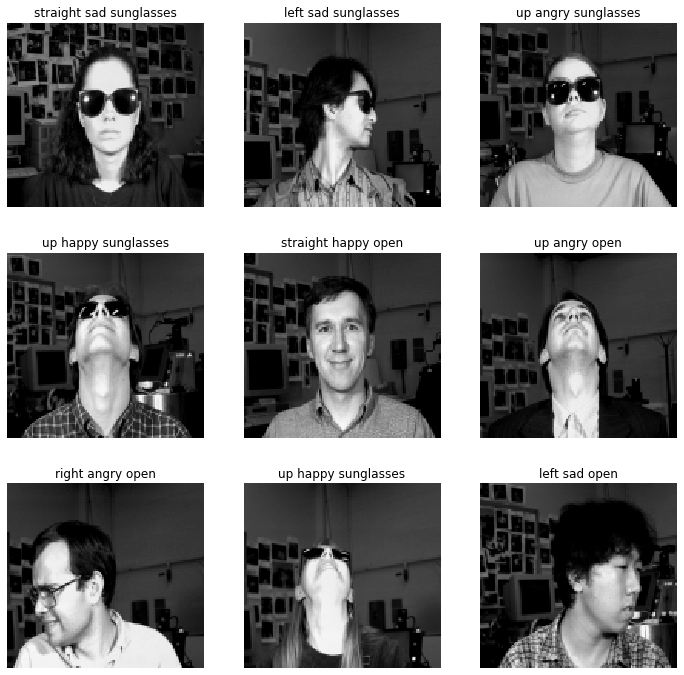

In [39]:
plt.figure(figsize=(12, 12))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(entera_imagenes[elegidas[i]])
    plt.title(" ".join(entera_nombres[elegidas[i]]))
    plt.axis("off")

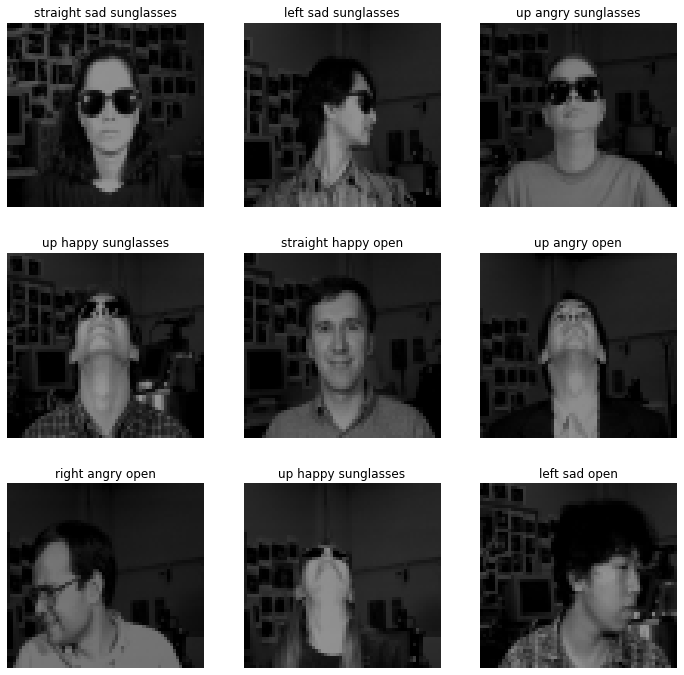

In [41]:
plt.figure(figsize=(12, 12))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(media_imagenes[elegidas[i]])
    plt.title(" ".join(media_nombres[elegidas[i]]))
    plt.axis("off")

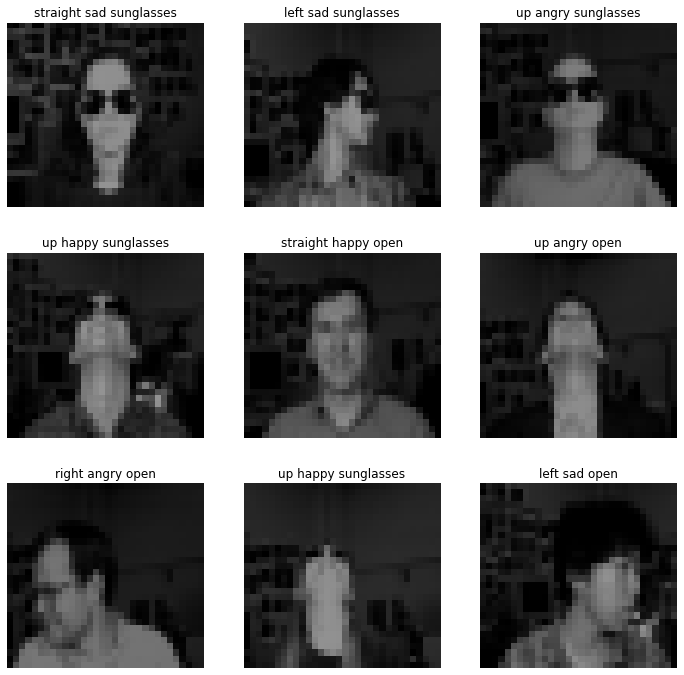

In [42]:
plt.figure(figsize=(12, 12))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(cuarto_imagenes[elegidas[i]])
    plt.title(" ".join(cuarto_nombres[elegidas[i]]))
    plt.axis("off")

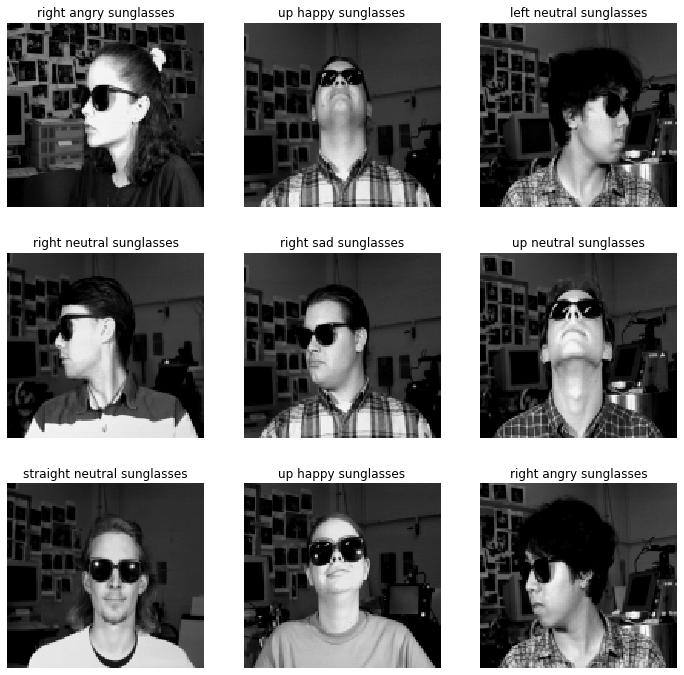

In [43]:
plt.figure(figsize=(12, 12))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(entera_con_gafas_imagenes[elegidas_con_gafas[i]])
    plt.title(" ".join(entera_con_gafas_nombres[elegidas_con_gafas[i]])+" sunglasses")
    plt.axis("off")

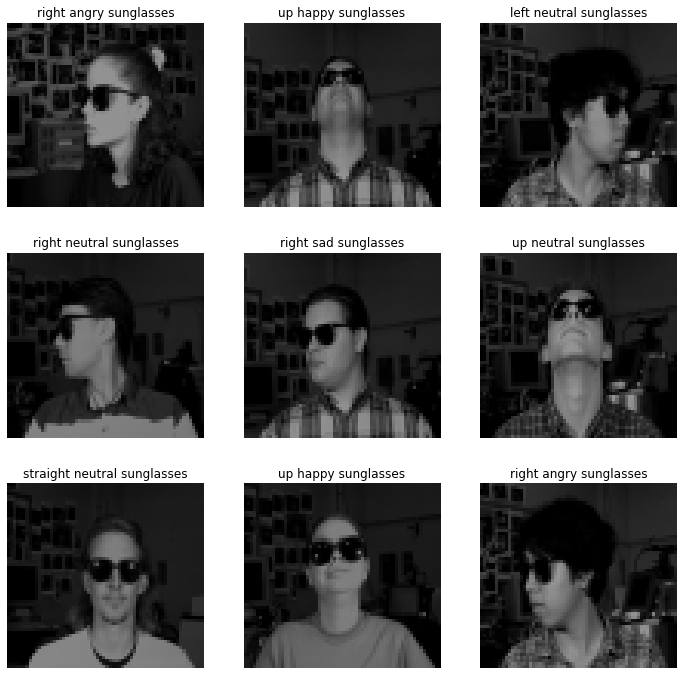

In [44]:
plt.figure(figsize=(12, 12))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(media_con_gafas_imagenes[elegidas_con_gafas[i]])
    plt.title(" ".join(media_con_gafas_nombres[elegidas_con_gafas[i]])+" sunglasses")
    plt.axis("off")

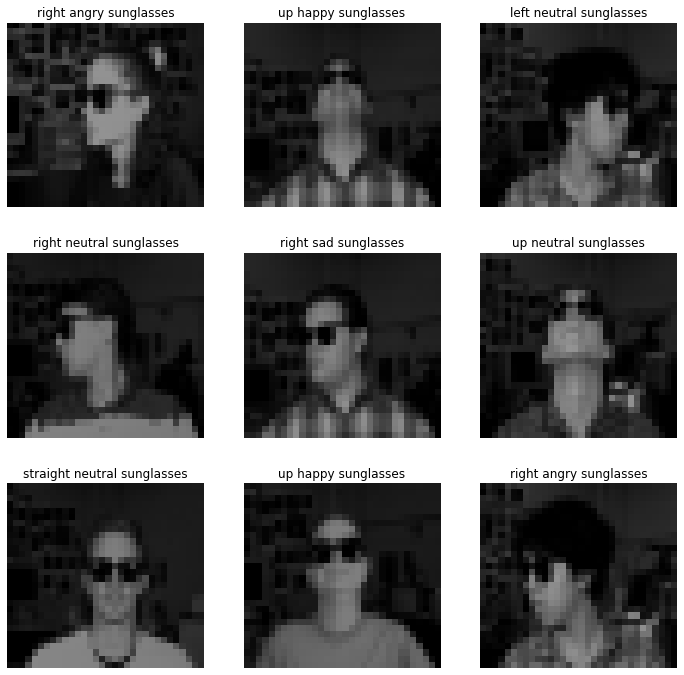

In [45]:
plt.figure(figsize=(12, 12))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(cuarto_con_gafas_imagenes[elegidas_con_gafas[i]])
    plt.title(" ".join(cuarto_con_gafas_nombres[elegidas_con_gafas[i]])+" sunglasses")
    plt.axis("off")

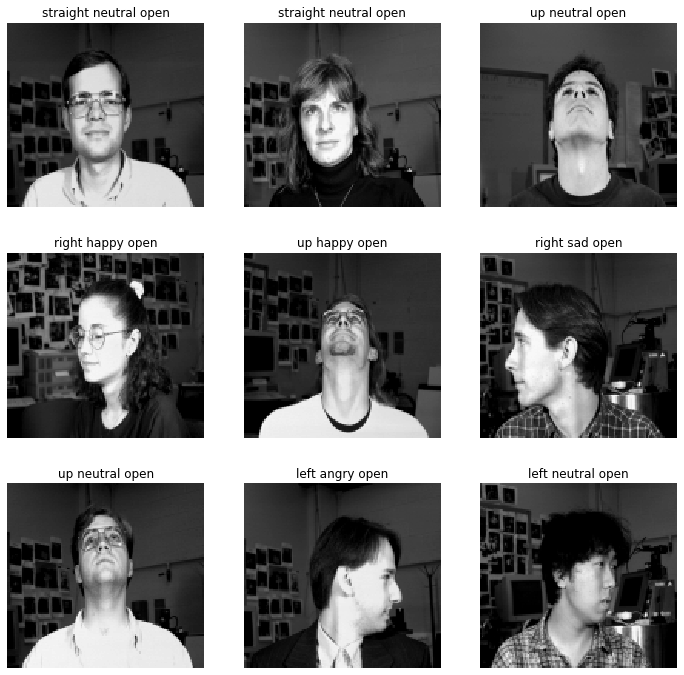

In [46]:
plt.figure(figsize=(12, 12))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(entera_sin_gafas_imagenes[elegidas_sin_gafas[i]])
    plt.title(" ".join(entera_sin_gafas_nombres[elegidas_sin_gafas[i]])+" open")
    plt.axis("off")

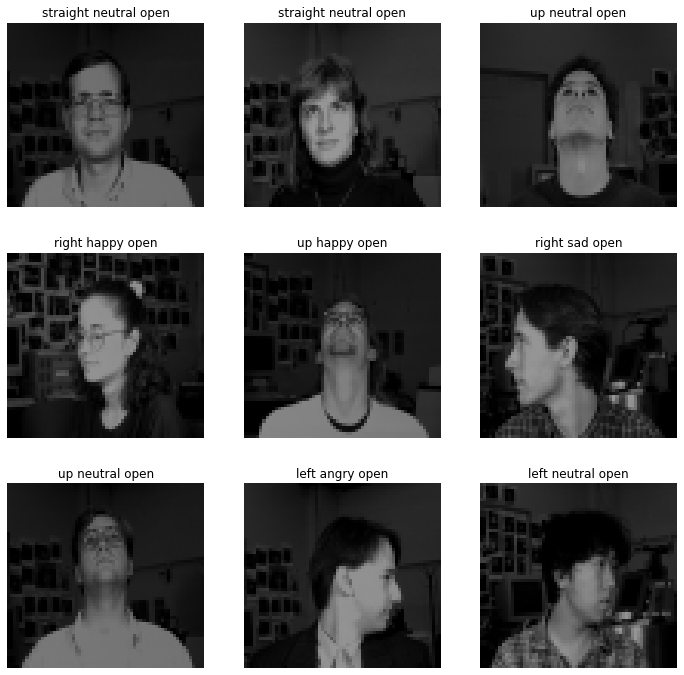

In [48]:
plt.figure(figsize=(12, 12))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(media_sin_gafas_imagenes[elegidas_sin_gafas[i]])
    plt.title(" ".join(media_sin_gafas_nombres[elegidas_sin_gafas[i]])+" open")
    plt.axis("off")

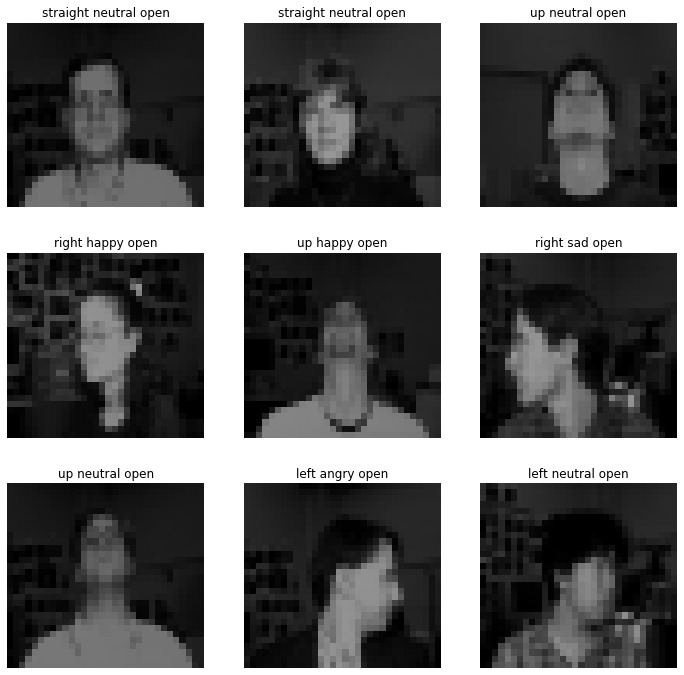

In [49]:
plt.figure(figsize=(12, 12))
for i in range(9):
    ax= plt.subplot(3, 3, i + 1)
    plt.imshow(cuarto_sin_gafas_imagenes[elegidas_sin_gafas[i]])
    plt.title(" ".join(cuarto_sin_gafas_nombres[elegidas_sin_gafas[i]])+" open")
    plt.axis("off")

In [52]:
print("La cantidad de imágenes con definición original es de "+str(len(entera_imagenes))+
      ", repartidas entre "+str(len(entera_con_gafas_imagenes))+" imágenes de personas con gafas y de "+
      str(len(entera_sin_gafas_imagenes))+" imágenes de personas sin gafas en diferentes posiciones y expresiones\n")

print("La resolución de estas imágenes es de "+len(entera_imagenes[0])+)

print("La cantidad de imágenes con definición de la mitad de la original es de "+str(len(entera_imagenes))+
      ", repartidas entre "+str(len(entera_con_gafas_imagenes))+" imágenes de personas con gafas y de "+
      str(len(entera_sin_gafas_imagenes))+" imágenes de personas sin gafas en diferentes posiciones y expresiones\n")
print("La cantidad de imágenes con definición de un cuarto de la original "+str(len(entera_imagenes))+
      ", repartidas entre "+str(len(entera_con_gafas_imagenes))+" imágenes de personas con gafas y de "+
      str(len(entera_sin_gafas_imagenes))+" imágenes de personas sin gafas en diferentes posiciones y expresiones\n")
      

La cantidad de imágenes con definición original es de 624, repartidas entre 311 imágenes de personas con gafas y de 313 imágenes de personas sin gafas en diferentes posiciones y expresiones

La cantidad de imágenes con definición de la mitad de la original es de 624, repartidas entre 311 imágenes de personas con gafas y de 313 imágenes de personas sin gafas en diferentes posiciones y expresiones

La cantidad de imágenes con definición de un cuarto de la original 624, repartidas entre 311 imágenes de personas con gafas y de 313 imágenes de personas sin gafas en diferentes posiciones y expresiones



In [62]:
print("La resolución de estas imágenes es de "+str(len(entera_imagenes[0]))+" filas con "+str(len(entera_imagenes[0][0]))+" columnas\n")
print("La resolución de estas imágenes es de "+str(len(media_imagenes[0]))+" filas con "+str(len(media_imagenes[0][0]))+" columnas\n")
print("La resolución de estas imágenes es de "+str(len(cuarto_imagenes[0]))+" filas con "+str(len(cuarto_imagenes[0][0]))+" columnas\n")

La resolución de estas imágenes es de 120 filas con 128 columnas

La resolución de estas imágenes es de 60 filas con 64 columnas

La resolución de estas imágenes es de 30 filas con 32 columnas



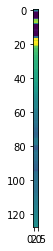

In [69]:
plt.imshow(entera_imagenes[0][1:5][0])

In [79]:
entera_imagenes[0][0][0]
hola = entera_imagenes[0][0][0].copy()
hola = hola[0]
print(hola, entera_imagenes[0][0][0])

34 [34 34 34]


['left', 'sad', 'sunglasses']
['right', 'sad']
624
311
313
624
311
313
624
311
313


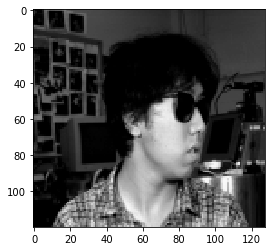

In [7]:
plt.imshow(entera_imagenes[7])
print(entera_nombres[7])
print(media_con_gafas_nombres[7])
print(len(entera_nombres))
print(len(entera_con_gafas_nombres))
print(len(entera_sin_gafas_nombres))
print(len(media_nombres))
print(len(media_con_gafas_nombres))
print(len(media_sin_gafas_nombres))
print(len(cuarto_nombres))
print(len(cuarto_con_gafas_nombres))
print(len(cuarto_sin_gafas_nombres))

### Preprocesamiento

### Implementación del modelo

### Predicción y conclusiones

## Referencias